# National mRS distributions

In [1]:
dir_output = 'output'
limit_to_england = False

## Import packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import stroke_outcome.outcome_utilities

pd.set_option('display.max_rows', 150)

In [3]:
stroke_outcome.__version__

'0.1.6'

## Load data

Results from outcome model:

In [4]:
df_mrs_national = pd.read_csv(os.path.join(dir_output, 'cohort_mrs_dists_weighted_national.csv'), index_col=0)

In [5]:
df_mrs_national.T

,National
drip_ship_lvo_ivt_mrs_dists_noncum_0,0.103557
drip_ship_lvo_ivt_mrs_dists_noncum_1,0.091883
drip_ship_lvo_ivt_mrs_dists_noncum_2,0.132440
drip_ship_lvo_ivt_mrs_dists_noncum_3,0.162241
drip_ship_lvo_ivt_mrs_dists_noncum_4,0.218449
...,...
mothership_weighted_mrs_dists_noncum_std_2,0.000132
mothership_weighted_mrs_dists_noncum_std_3,0.000165
mothership_weighted_mrs_dists_noncum_std_4,0.000673
mothership_weighted_mrs_dists_noncum_std_5,0.000384


In [6]:
# Remove repeats from all the mRS bands:
cols_each_scen = sorted(list(set([c.split('mrs_dists')[0] + 'mrs_dists' for c in df_mrs_national.columns])))

cols_each_scen

['drip_ship_lvo_ivt_mrs_dists',
 'drip_ship_lvo_ivt_mt_mrs_dists',
 'drip_ship_lvo_mix_mrs_dists',
 'drip_ship_lvo_mt_mrs_dists',
 'drip_ship_nlvo_ivt_mrs_dists',
 'drip_ship_weighted_mrs_dists',
 'mothership_lvo_ivt_mrs_dists',
 'mothership_lvo_ivt_mt_mrs_dists',
 'mothership_lvo_mix_mrs_dists',
 'mothership_lvo_mt_mrs_dists',
 'mothership_nlvo_ivt_mrs_dists',
 'mothership_weighted_mrs_dists']

Reference no-treatment mRS distributions:

In [7]:
mrs_dists, mrs_dists_notes = (
    stroke_outcome.outcome_utilities.import_mrs_dists_from_file())

In [8]:
mrs_dists

,mRS<=0,mRS<=1,mRS<=2,mRS<=3,mRS<=4,mRS<=5,mRS<=6
Stroke type,,,,,,,
pre_stroke_nlvo,0.583,0.746,0.850,0.951,0.993,1.000,1
pre_stroke_lvo,0.408,0.552,0.672,0.838,0.956,1.000,1
no_treatment_lvo,0.050,0.129,0.265,0.429,0.676,0.811,1
no_treatment_nlvo,0.198,0.460,0.580,0.708,0.856,0.918,1
no_effect_nlvo_ivt_deaths,0.196,0.455,0.574,0.701,0.847,0.908,1
no_effect_lvo_ivt_deaths,0.048,0.124,0.255,0.414,0.653,0.783,1
no_effect_lvo_mt_deaths,0.048,0.124,0.255,0.412,0.649,0.779,1
t0_treatment_nlvo_ivt,0.445,0.642,0.752,0.862,0.941,0.967,1
t0_treatment_lvo_ivt,0.140,0.233,0.361,0.522,0.730,0.838,1


In [9]:
mrs_dist_nlvo_no_treatment = mrs_dists.loc['no_treatment_nlvo'].values
mrs_dist_lvo_no_treatment = mrs_dists.loc['no_treatment_lvo'].values

mrs_dist_nlvo_no_treatment_noncum = np.diff(mrs_dist_nlvo_no_treatment, prepend=0.0)
mrs_dist_lvo_no_treatment_noncum = np.diff(mrs_dist_lvo_no_treatment, prepend=0.0)

Stroke type proportions:

In [10]:
proportions = pd.read_csv(
    os.path.join(dir_output, 'patient_proportions.csv'),
    index_col=0, header=None).squeeze()

In [11]:
proportions

0
haemorrhagic         0.13600
lvo_no_treatment     0.14648
lvo_ivt_only         0.00840
lvo_ivt_mt           0.08500
lvo_mt_only          0.01500
nlvo_no_treatment    0.50252
nlvo_ivt             0.10660
Name: 1, dtype: float64

### Calculate weighted no treatment dist:

In [12]:
prop_lvo = 0.0
prop_nlvo = 0.0

for key, value in proportions.items():
    if 'nlvo' in key:
        prop_nlvo += value
    elif 'lvo' in key:
        prop_lvo += value

In [13]:
prop_lvo, prop_nlvo

(0.25488, 0.60912)

In [14]:
mrs_dist_weighted_no_treatment_noncum = (
    (mrs_dist_nlvo_no_treatment_noncum * prop_nlvo) +
    (mrs_dist_lvo_no_treatment_noncum * prop_lvo)
)

# Remove the non-ischaemic patients:
mrs_dist_weighted_no_treatment_noncum = (
    mrs_dist_weighted_no_treatment_noncum / (prop_nlvo + prop_lvo)
)

In [15]:
np.sum(mrs_dist_weighted_no_treatment_noncum)

0.9999999999999999

In [16]:
dict_no_treat = {
    'nlvo': mrs_dist_nlvo_no_treatment_noncum,
    'lvo': mrs_dist_lvo_no_treatment_noncum,
    'weighted': mrs_dist_weighted_no_treatment_noncum,
}

## Gather data for plots

In [17]:
def gather_dists(scenario):
    d = {}

    for cohort in ['nlvo_ivt', 'lvo_mix', 'weighted']:
        cols_noncum = [c for c in df_mrs_national.columns if ((c.startswith(f'{scenario}_{cohort}_mrs_dists_noncum')) & ('std' not in c))]
        cols_std = [c for c in df_mrs_national.columns if ((c.startswith(f'{scenario}_{cohort}_mrs_dists_noncum')) & ('std' in c))]

        d[cohort] = {}
        d[cohort]['values'] = df_mrs_national[cols_noncum].values[0]
        d[cohort]['std'] = df_mrs_national[cols_std].values[0]
    
    return d

In [18]:
dict_drip_ship = gather_dists('drip_ship')
dict_mothership = gather_dists('mothership')

## Plot

In [21]:
colour_drip = '#00517f'   # seaborn colorblind blue darker
colour_moth = '#0072b2'  # seaborn colorblind blue
colour_no_treat = 'grey'

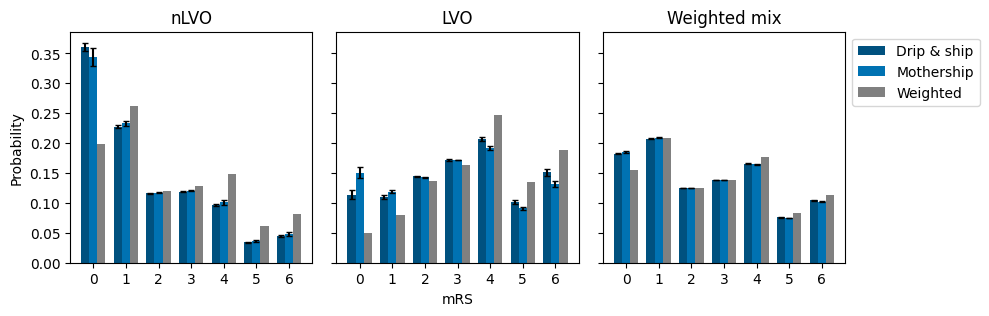

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True, gridspec_kw={'wspace': 0.1})

bar_width = 0.25
offsets = [-bar_width, 0.0, bar_width]

legend_drawn = False
for c, cohort in enumerate(['nlvo_ivt', 'lvo_mix', 'weighted']):
    dist_drip = dict_drip_ship[cohort]['values']
    std_drip = dict_drip_ship[cohort]['std']
    dist_moth = dict_mothership[cohort]['values']
    std_moth = dict_mothership[cohort]['std']
    
    if 'nlvo' in cohort:
        ax = axs[0]
        dist_no_treat = dict_no_treat['nlvo']
    elif 'lvo' in cohort:
        ax = axs[1]
        dist_no_treat = dict_no_treat['lvo']
    else:
        ax = axs[2]
        dist_no_treat = dict_no_treat['weighted']

    ax.bar(
        np.arange(7) + offsets[0], dist_drip, yerr=std_drip, capsize=2.0,
        facecolor=colour_drip, label='Drip & ship', width=bar_width
        )
    ax.bar(
        np.arange(7) + offsets[1], dist_moth, yerr=std_moth, capsize=2.0,
        facecolor=colour_moth, label='Mothership', width=bar_width
        )
    ax.bar(
        np.arange(7) + offsets[2], dist_no_treat,
        facecolor=colour_no_treat, label='Weighted', width=bar_width
        )

    if legend_drawn is False:
        ax.legend(bbox_to_anchor=(3.2, 1.0), loc='upper left')
        legend_drawn = True

for ax in axs:
    ax.set_xticks(range(7))

axs[0].set_title('nLVO')
axs[1].set_title('LVO')
axs[2].set_title('Weighted mix')

axs[0].set_ylabel('Probability')
axs[1].set_xlabel('mRS')

plt.show()